In [9]:
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


metrics_dict = {}
sys.path.append('../')

from utils import utils, model_fetch

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Which model to evaluate


####### Change This #######
model_of_interest = "cutmix"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "baseline_teacher": base_path + 'resnet18_baseline_retrained_1586751743/model_best.pth.tar',
    "mixup_teacher": base_path + 'resnet18_mixup_retrained_1586457991/checkpoint.pth.tar',
    "cutout_teacher": base_path + 'resnet18-cutout-restart-again_1586956477/model_best.pth.tar',
    "cutmix_teacher": base_path + 'resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar',
    "augmented_teacher": base_path + 'resnet18_augmented_retrained_1586751381/checkpoint.pth.tar',
    
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
    "augmented": base_path + ''
}
if 'teacher' in model_of_interest:
    model = model_fetch.fetch_student('resnet18')
else:
    model = model_fetch.fetch_student('lenet')

_, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_of_interest])
model.eval()

=> Loading Checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar' (epoch 250)
Current Loss :  1.088435726829722


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# CINIC ImageNet Section - Dataloading

# cinic_directory = '../data/cinic-10-cifar/'
cinic_directory = '../data/cinic-10-imagenet/'

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + 'test',
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
        batch_size=1, shuffle=False)

# CINIC Imagenet Section Predictions 

preds = []
y_true = []
for i in range(10):
    y_true.extend([i]*7000)
for label, img  in enumerate(cinic_test):
    preds.append(model(img[0]).detach().numpy())
    
y_true = np.array(y_true)
preds = np.array(preds).squeeze(1)

In [17]:
# Update existing Metrics Dictionary
# preds = np.array(preds).squeeze(1)

metrics = utils.find_metrics(preds, np.array(y_true), False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,baseline,cutmix
accuracy,0.456957,0.439314
precision,0.451836,0.434007
recall,0.456957,0.439314
f1-score,0.449389,0.434692


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

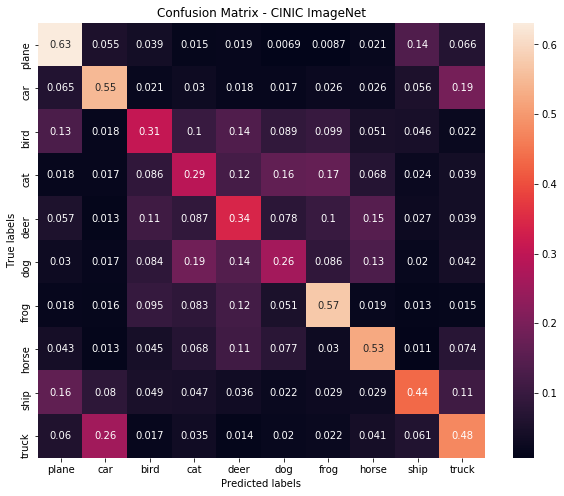

In [18]:
# Plot Confusion Matrix

y_pred = np.argmax(preds, axis=1)
conf_mat = cm(y_true, y_pred, normalize='true')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CINIC ImageNet')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)

In [19]:
pd.DataFrame(metrics_dict)

,baseline,cutmix
accuracy,0.456957,0.439314
precision,0.451836,0.434007
recall,0.456957,0.439314
f1-score,0.449389,0.434692


In [21]:
METRICS_STUDENT_DICT = {
    "baseline": {
        "accuracy": 0.456957,
        "precision": 0.451836,
        "recall": 0.456957,
        "f1-score": 0.449389,
    },
     "mixup": {
        "accuracy": 0.443657,
        "precision": 0.435142,
        "recall": 0.443657,
        "f1-score": 0.432727,
     },
     "cutmix": {
        "accuracy": 0.439314,
        "precision": 0.434007,
        "recall": 0.439314,
        "f1-score": 0.434692,
     },
     "cutout": {
        "accuracy": 0.450600,
        "precision": 0.447214,
        "recall": 0.450600,
        "f1-score": 0.445054,
     },
     "augmented": {}
}


In [6]:
# CINIC CIFAR Section - Dataloading

cinic_directory = '../data/cinic-10-cifar/'
# cinic_directory = '../data/cinic-10-imagenet/'

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
cinic_test = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + 'test',
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
        batch_size=1, shuffle=False)

# CINIC CIFAR Section Predictions 

preds = []
y_true = []
for i in range(10):
    y_true.extend([i]*2000)
for label, img  in enumerate(cinic_test):
    preds.append(model(img[0]).detach().numpy())
    
y_true = np.array(y_true)
preds = np.array(preds).squeeze(1)

In [7]:
# Update existing Metrics Dictionary
# preds = np.array(preds).squeeze(1)

metrics = utils.find_metrics(preds, np.array(y_true), False)
metrics_df = metrics_dict.update({model_of_interest:
    {
        "accuracy": metrics[0],
        "precision": metrics[1],
        "recall": metrics[2],
        "f1-score": metrics[3]
    }})

pd.DataFrame(metrics_dict)

,cutout
accuracy,0.707300
f1-score,0.706708
precision,0.706607
recall,0.707300


[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

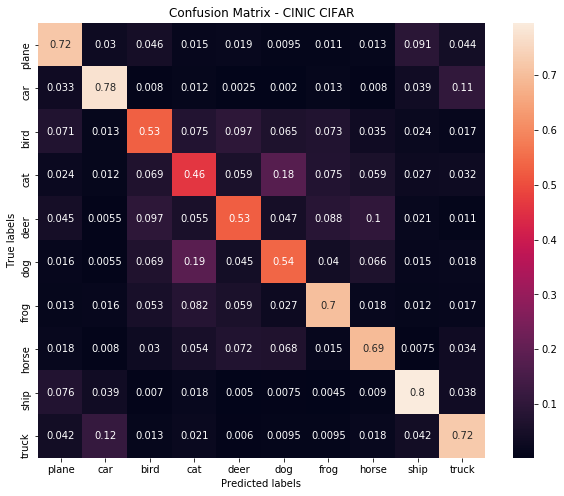

In [22]:
# Plot Confusion Matrix

y_pred = np.argmax(preds, axis=1)
conf_mat = cm(y_true, y_pred, normalize='true')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - CINIC CIFAR')
ax.xaxis.set_ticklabels(_CLASSES)
ax.yaxis.set_ticklabels(_CLASSES)